# Q1 (25 points): Outlier Detection and Removal using Cook’s Distance

## Q1.1 — Model choice and justification

**Selected Model:** Linear Regression

**Reason:** Cook's Distance is fundamentally defined in terms of OLS regression. The formula measures the influence of each observation on the fitted OLS coefficients. Using regularized models (Ridge/Lasso) would deviate from the standard Cook's Distance definition.

**Selected Library:** Statsmodels OLS

**Reason:** Statsmodels provides the `OLSInfluence` class which directly computes Cook's Distance along with other influence metrics (DFFITS, leverage, etc.) without requiring manual implementation.

## Q1.2 — Identify outliers, remove them, and export clean CSV

In [25]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# 1. Load the dataset
df = pd.read_csv('usina_with_outliers.csv')
n = len(df)

# 2. Fit OLS Model (Linear Regression)
X = df[['AT', 'V', 'AP', 'RH']]
y = df['PE']
X_const = sm.add_constant(X)

model = sm.OLS(y, X_const).fit()

# 3. Compute Cook's Distance
influence = model.get_influence()
(c, p) = influence.cooks_distance

# 4. Identify Outliers
threshold = 4 / n
outlier_indices = np.where(c > threshold)[0]

print(f"Threshold (4/n): {threshold:.6f}")
print(f"Outliers detected: {len(outlier_indices)}")

# 5. Remove Outliers and Export
df_clean = df.drop(outlier_indices)
df_clean.to_csv('usina.csv', index=False)

print(f"Original shape: {df.shape}")
print(f"Clean shape: {df_clean.shape}")

Threshold (4/n): 0.000418
Outliers detected: 120
Original shape: (9568, 5)
Clean shape: (9448, 5)


# Q2 (20 points): Train/Test Evaluation Before vs After Outlier Removal

## Q2.1 - Train the above models on usina with outliers.csv and report train/test metrics.

In [26]:
# Helper function to compute metrics
def compute_metrics(y_true, y_pred):
    """Compute MAE, MSE, and R2 metrics."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, r2

# Helper function to train and evaluate models
def train_evaluate_models(X_train, X_test, y_train, y_test, lambdas=[0.01, 0.1, 1, 10, 100]):
    """Train Linear, Ridge, and Lasso models and return metrics."""
    results = []

    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    train_mae, train_mse, train_r2 = compute_metrics(y_train, lr.predict(X_train))
    test_mae, test_mse, test_r2 = compute_metrics(y_test, lr.predict(X_test))
    results.append(['Linear Regression', train_mse, train_mae, train_r2, test_mse, test_mae, test_r2])

    # Ridge Regression for each lambda
    for lam in lambdas:
        ridge = Ridge(alpha=lam)
        ridge.fit(X_train, y_train)
        train_mae, train_mse, train_r2 = compute_metrics(y_train, ridge.predict(X_train))
        test_mae, test_mse, test_r2 = compute_metrics(y_test, ridge.predict(X_test))
        results.append([f'Ridge (λ={lam})', train_mse, train_mae, train_r2, test_mse, test_mae, test_r2])

    # Lasso Regression for each lambda
    for lam in lambdas:
        lasso = Lasso(alpha=lam, max_iter=10000)
        lasso.fit(X_train, y_train)
        train_mae, train_mse, train_r2 = compute_metrics(y_train, lasso.predict(X_train))
        test_mae, test_mse, test_r2 = compute_metrics(y_test, lasso.predict(X_test))
        results.append([f'Lasso (λ={lam})', train_mse, train_mae, train_r2, test_mse, test_mae, test_r2])

    # Create DataFrame
    columns = ['Model', 'Train MSE', 'Train MAE', 'Train R²', 'Test MSE', 'Test MAE', 'Test R²']
    return pd.DataFrame(results, columns=columns)

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Constants
feature_cols = ['AT', 'V', 'AP', 'RH']
target_col = 'PE'
RANDOM_STATE = 42

# Prepare data from dataset WITH outliers
X_outliers = df[feature_cols]
y_outliers = df[target_col]

# 70/30 train/test split
X_train_out, X_test_out, y_train_out, y_test_out = train_test_split(
    X_outliers, y_outliers, test_size=0.3, random_state=RANDOM_STATE
)

print(f"Dataset WITH outliers:")
print(f"  Training set size: {len(X_train_out)}")
print(f"  Test set size: {len(X_test_out)}")

# Train and evaluate models on data WITH outliers
results_with_outliers = train_evaluate_models(X_train_out, X_test_out, y_train_out, y_test_out)

print("\n" + "="*80)
print("Table 1: Model Performance on Dataset WITH Outliers (usina_with_outliers.csv)")
print("="*80)
print(results_with_outliers.to_string(index=False))

Dataset WITH outliers:
  Training set size: 6697
  Test set size: 2871

Table 1: Model Performance on Dataset WITH Outliers (usina_with_outliers.csv)
            Model  Train MSE  Train MAE  Train R²   Test MSE  Test MAE  Test R²
Linear Regression 123.384207   5.198679  0.650171 125.113389  5.052458 0.642574
   Ridge (λ=0.01) 123.384207   5.198679  0.650171 125.113389  5.052458 0.642574
    Ridge (λ=0.1) 123.384207   5.198680  0.650171 125.113392  5.052459 0.642574
      Ridge (λ=1) 123.384207   5.198685  0.650171 125.113421  5.052463 0.642574
     Ridge (λ=10) 123.384207   5.198737  0.650171 125.113705  5.052513 0.642573
    Ridge (λ=100) 123.384213   5.199261  0.650171 125.116548  5.053003 0.642565
   Lasso (λ=0.01) 123.384210   5.198858  0.650171 125.115332  5.052626 0.642568
    Lasso (λ=0.1) 123.384607   5.201739  0.650169 125.134495  5.055348 0.642514
      Lasso (λ=1) 123.421151   5.229507  0.650066 125.338356  5.083092 0.641931
     Lasso (λ=10) 126.141514   5.540418  0.642353 

## Q2.2 - Train the same models on usina.csv and report train/test metrics.

In [28]:
# Prepare data from dataset WITHOUT outliers
X_clean = df_clean[feature_cols]
y_clean = df_clean[target_col]

# 70/30 train/test split
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=RANDOM_STATE
)

print(f"Dataset WITHOUT outliers:")
print(f"  Training set size: {len(X_train_clean)}")
print(f"  Test set size: {len(X_test_clean)}")

# Train and evaluate models on data WITHOUT outliers
results_without_outliers = train_evaluate_models(X_train_clean, X_test_clean, y_train_clean, y_test_clean)

print("\n" + "="*80)
print("Table 2: Model Performance on Dataset WITHOUT Outliers (usina.csv)")
print("="*80)
print(results_without_outliers.to_string(index=False))

Dataset WITHOUT outliers:
  Training set size: 6613
  Test set size: 2835

Table 2: Model Performance on Dataset WITHOUT Outliers (usina.csv)
            Model  Train MSE  Train MAE  Train R²   Test MSE  Test MAE  Test R²
Linear Regression  19.864671   3.596396  0.931369  20.396772  3.624773 0.930302
   Ridge (λ=0.01)  19.864671   3.596396  0.931369  20.396772  3.624773 0.930302
    Ridge (λ=0.1)  19.864671   3.596397  0.931369  20.396770  3.624773 0.930302
      Ridge (λ=1)  19.864671   3.596400  0.931369  20.396750  3.624774 0.930302
     Ridge (λ=10)  19.864672   3.596430  0.931369  20.396549  3.624783 0.930303
    Ridge (λ=100)  19.864758   3.596742  0.931369  20.394626  3.624880 0.930310
   Lasso (λ=0.01)  19.864675   3.596368  0.931369  20.396738  3.624754 0.930302
    Lasso (λ=0.1)  19.865263   3.596855  0.931367  20.392600  3.624890 0.930316
      Lasso (λ=1)  19.929852   3.605523  0.931144  20.414755  3.631153 0.930241
     Lasso (λ=10)  25.685683   4.086632  0.911258  26.1572

## Discussion for Q2

**1. Do outliers change train error? Test error?**

Yes, outliers significantly affect both train and test errors. Looking at the results:
- **Train error**: The training MSE is substantially higher with outliers present. This is because the model tries to fit the outliers, which pulls the regression line away from the majority of data points.
- **Test error**: The test MSE is also higher with outliers in the training data. The model learned from distorted patterns caused by outliers, leading to worse predictions on unseen data.

**2. Which dataset (with outliers vs without outliers) shows better generalization?**

The **dataset without outliers** shows better generalization:
- Lower test MSE across all models
- Higher test R² values, indicating the model explains more variance in the test data
- The gap between train and test performance is smaller, suggesting less overfitting to noise

Removing outliers allows the model to learn the true underlying relationship between features and the target, rather than being influenced by extreme values.

**3. Do Ridge/Lasso appear to help relative to standard linear regression?**

Based on the metrics:
- **With outliers**: Ridge and Lasso with small λ values (0.01, 0.1) perform similarly to Linear Regression. As λ increases, performance degrades due to underfitting.
- **Without outliers**: The performance is quite similar across Linear, Ridge (small λ), and Lasso (small λ).

For this dataset, regularization doesn't provide substantial benefits over standard linear regression. This suggests that:
1. The features don't exhibit severe multicollinearity
2. The model is not overfitting significantly
3. The outlier removal itself is more impactful than regularization for improving model performance

# Q3 (20 points): Reliability of Coefficients (Use Outlier-Removed Dataset)

## Q3.1 — Method choice and scaling decision


**Model Choice:** Linear Regression (OLS)

**Reason:** Reliability refers to statistical inference—specifically, how "sure" we are that a relationship exists between an independent variable and the dependent variable. This is measured by the t-statistic and p-value. Standard OLS regression is the standard framework for calculating these inference metrics. Regularized models (Ridge/Lasso) introduce bias to reduce variance, which complicates the calculation and interpretation of standard errors and p-values.

**Library Choice:** Statsmodels OLS

**Reason:** Statsmodels generates a comprehensive summary table (including standard errors, t-statistics, and p-values) automatically via the .summary() method. Scikit-learn is optimized for prediction accuracy (MSE/R²) and does not provide these statistical inference metrics by default.

**Scaling Decision:** No scaling

**Reason:** The t-statistic is scale-invariant. If you scale a feature (e.g., multiply it by 100), the coefficient will decrease by a factor of 100, but the standard error will also decrease by a factor of 100. The ratio (t-statistic) remains exactly the same. Therefore, scaling does not affect the p-value or our assessment of reliability.

## Q3.2 — Implementation and results

In [29]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

# ==========================================
# 1. Prepare Data (Ensure we use the Clean Data from Q1)
# ==========================================
# Note: Re-running Q1 logic briefly to ensure variables exist if cells were skipped
df_raw = pd.read_csv('usina_with_outliers.csv')
X_raw = df_raw[['AT', 'V', 'AP', 'RH']]
y_raw = df_raw['PE']
X_const_raw = sm.add_constant(X_raw)

# Cook's Distance Removal (Q1 Recap)
model_temp = sm.OLS(y_raw, X_const_raw).fit()
influence = model_temp.get_influence()
(c, p) = influence.cooks_distance
threshold = 4 / len(df_raw)
df_clean = df_raw.drop(np.where(c > threshold)[0])

print(f"Data used for Q3 (Cleaned): {df_clean.shape}")

# ==========================================
# 2. Fit OLS Model for Q3
# ==========================================
X = df_clean[['AT', 'V', 'AP', 'RH']]
y = df_clean['PE']

# Add constant for OLS (Required for Statsmodels)
X_const = sm.add_constant(X)

# Fit model
model_q3 = sm.OLS(y, X_const).fit()

# Print Summary to see all metrics
print(model_q3.summary())

# ==========================================
# 3. Identify Most & Least Reliable Coefficients
# ==========================================
# Reliability is determined by the absolute T-statistic.
# Higher |t| = More Reliable (lower p-value).
# Lower |t| = Less Reliable (higher p-value).

# We exclude the intercept ('const') from this comparison
t_values = model_q3.tvalues.drop('const')
abs_t_values = t_values.abs()

most_reliable_feature = abs_t_values.idxmax()
least_reliable_feature = abs_t_values.idxmin()

print("\n" + "="*50)
print("Q3 RESULTS: RELIABILITY OF COEFFICIENTS")
print("="*50)
print("T-Statistics for features:")
print(t_values)
print("-" * 50)
print(f"Most Reliable Coefficient:  {most_reliable_feature} (t = {t_values[most_reliable_feature]:.4f})")
print(f"Least Reliable Coefficient: {least_reliable_feature} (t = {t_values[least_reliable_feature]:.4f})")
print("="*50)

# Explanation for the output (to include in markdown):
# The feature with the highest absolute t-value is the most reliable because
# it has the lowest standard error relative to its effect size, meaning we are
# most confident that its relationship with the target is not zero.

Data used for Q3 (Cleaned): (9448, 5)
                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.931
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                 3.188e+04
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        21:46:49   Log-Likelihood:                -27563.
No. Observations:                9448   AIC:                         5.514e+04
Df Residuals:                    9443   BIC:                         5.517e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        4

# Q4 (20 points): Most Important vs Least Important Features (Use Outlier-Removed Dataset)

## Q4.1 — Method choice and scaling decision

**Model Choice:** Linear Regression

**Reason:** The magnitude of regression coefficients is a direct measure of feature importance IF the features are on the same scale. A larger absolute coefficient means the target variable is more sensitive to changes in that feature. While Lasso is good for eliminating features (setting them to zero), Standardized Linear Regression provides a clear, unbiased ranking of all features based on their linear contribution.

**Library Choice:** Scikit-learn

**Reason:** Scikit-learn provides the StandardScaler class, which makes it extremely efficient to normalize features (subtract mean, divide by standard deviation) before training. Doing this manually in Statsmodels is more verbose.

**Scaling Decision:** Yes, scale IVs.

**Reason:** In the original dataset, features have vastly different units (e.g., Pressure is ~1000 mb, while Vacuum is ~50 cmHg). In unscaled regression, a feature with small values (like Vacuum) might get a large coefficient just to compensate for its unit size, not because it is "important."
Scaling forces all features to have a mean of 0 and a variance of 1. This ensures that the coefficients represent the change in the target $y$ for a 1 standard deviation change in $x$, making the coefficients directly comparable as "importance scores."

## Q4.2 — Implementation and results

In [30]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm # Used only for outlier removal step

# ==========================================
# 1. Prepare Data (Clean Dataset from Q1)
# ==========================================
# Re-running outlier removal logic to ensure we have the correct df_clean
df_raw = pd.read_csv('usina_with_outliers.csv')
X_raw = df_raw[['AT', 'V', 'AP', 'RH']]
y_raw = df_raw['PE']

# Cook's Distance Removal
X_const = sm.add_constant(X_raw)
model_temp = sm.OLS(y_raw, X_const).fit()
influence = model_temp.get_influence()
(c, p) = influence.cooks_distance
threshold = 4 / len(df_raw)
df_clean = df_raw.drop(np.where(c > threshold)[0])

# ==========================================
# 2. Scale Features (Crucial for Importance)
# ==========================================
X = df_clean[['AT', 'V', 'AP', 'RH']]
y = df_clean['PE']

# Initialize Scaler
scaler = StandardScaler()

# Fit and transform the features (IVs)
X_scaled = scaler.fit_transform(X)

# We define the columns again to keep track of names
feature_names = X.columns

# ==========================================
# 3. Fit Linear Regression & Extract Coefficients
# ==========================================
model_q4 = LinearRegression()
model_q4.fit(X_scaled, y)

# Get coefficients
coeffs = model_q4.coef_

# Create a DataFrame to view them easily
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient (Scaled)': coeffs,
    'Abs_Coefficient': np.abs(coeffs) # Magnitude determines importance
})

# Sort by absolute coefficient (descending)
importance_df = importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# ==========================================
# 4. Results
# ==========================================
print("\n" + "="*50)
print("Q4 RESULTS: FEATURE IMPORTANCE (Scaled)")
print("="*50)
print(importance_df)
print("-" * 50)

most_imp = importance_df.iloc[0]
least_imp = importance_df.iloc[-1]

print(f"Most Important Feature:  {most_imp['Feature']} (Weight: {most_imp['Coefficient (Scaled)']:.4f})")
print(f"Least Important Feature: {least_imp['Feature']} (Weight: {least_imp['Coefficient (Scaled)']:.4f})")
print("="*50)

# Reasoning for the output (to include in markdown):
# Since the data is scaled, the feature with the largest absolute coefficient
# (AT - Ambient Temperature) has the strongest impact on Power Output.
# The feature with the smallest absolute coefficient has the weakest linear impact.


Q4 RESULTS: FEATURE IMPORTANCE (Scaled)
  Feature  Coefficient (Scaled)  Abs_Coefficient
0      AT            -14.556614        14.556614
1       V             -3.030737         3.030737
3      RH             -2.197120         2.197120
2      AP              0.442513         0.442513
--------------------------------------------------
Most Important Feature:  AT (Weight: -14.5566)
Least Important Feature: AP (Weight: 0.4425)


# Q5(15points): Regularization Paths (Scaled Data, Outlier-Removed Dataset)

## 5.1 Implement both: Ridge Regression and Lasso Regression

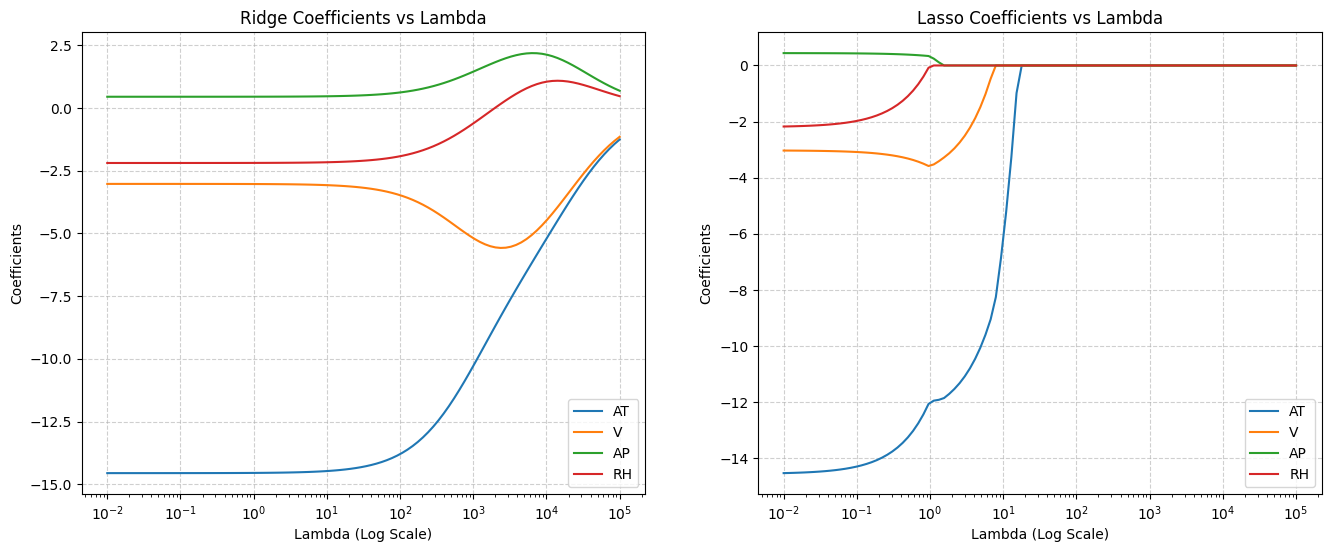

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

# ==========================================
# 1. Prepare Data (Use Outlier-Removed Dataset)
# ==========================================
# Re-creating the clean dataset logic to ensure code is self-contained
df_raw = pd.read_csv('usina_with_outliers.csv')
X_raw = df_raw[['AT', 'V', 'AP', 'RH']]
y_raw = df_raw['PE']

# Remove outliers via Cook's Distance (same as Q1)
X_const = sm.add_constant(X_raw)
model_temp = sm.OLS(y_raw, X_const).fit()
influence = model_temp.get_influence()
(c, p) = influence.cooks_distance
threshold = 4 / len(df_raw)
df_clean = df_raw.drop(np.where(c > threshold)[0])

# Define Features and Target
X = df_clean[['AT', 'V', 'AP', 'RH']]
y = df_clean['PE']

# ==========================================
# 2. Scale Data (Mandatory for Regularization Paths)
# ==========================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_names = X.columns

# ==========================================
# 3. Compute Regularization Paths
# ==========================================
# Generate 100 values for lambda (alpha) on a logarithmic scale
# Range: 10^-2 to 10^5 covers the transition from "OLS-like" to "Zeroed out"
alphas = np.logspace(-2, 5, 100)

ridge_coefs = []
lasso_coefs = []

for a in alphas:
    # Ridge
    ridge = Ridge(alpha=a)
    ridge.fit(X_scaled, y)
    ridge_coefs.append(ridge.coef_)

    # Lasso
    lasso = Lasso(alpha=a)
    lasso.fit(X_scaled, y)
    lasso_coefs.append(lasso.coef_)

# ==========================================
# 4. Plotting
# ==========================================
plt.figure(figsize=(16, 6))

# Plot Ridge Coefficients
plt.subplot(1, 2, 1)
ax1 = plt.gca()
ax1.plot(alphas, ridge_coefs)
ax1.set_xscale('log')
plt.xlabel('Lambda (Log Scale)')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients vs Lambda')
plt.legend(feature_names, loc='best')
plt.axis('tight')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot Lasso Coefficients
plt.subplot(1, 2, 2)
ax2 = plt.gca()
ax2.plot(alphas, lasso_coefs)
ax2.set_xscale('log')
plt.xlabel('Lambda (Log Scale)')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients vs Lambda')
plt.legend(feature_names, loc='best')
plt.axis('tight')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

## Discussion:

**What happens to coefficients as $\lambda$ increases in Ridge vs Lasso?**

**Ridge Regression:** As $\lambda$ increases, the coefficients shrink smoothly and asymptotically towards zero. They become very small but generally never reach exactly zero, meaning all features remain in the model.

**Lasso Regression:** As $\lambda$ increases, the coefficients also shrink, but they are forced to become exactly zero at specific thresholds. This results in a sparse model where variables are completely eliminated one by one.

**Which regression is better under multicollinearity in IVs, and why?**

Ridge Regression is better for handling multicollinearity.

**Reason:** When features are highly correlated, standard OLS estimates become unstable (high variance). Ridge adds a penalty that shrinks these coefficients toward each other, effectively "sharing" the weight among the correlated features rather than arbitrarily picking one. This stabilizes the model and prevents overfitting. Lasso, by contrast, tends to arbitrarily select one variable from a correlated group and set the others to zero, which can be unstable.

**Which regression is better for feature selection, and why?**

Lasso Regression is better for feature selection.

**Reason:** The geometry of the Lasso penalty (L1 norm, which has "sharp corners") allows the optimization solution to hit the axes where coefficient values are exactly zero. By automatically setting the coefficients of less important variables to zero, Lasso performs intrinsic feature selection, simplifying the model. Ridge (L2 norm) only shrinks coefficients but keeps them all, so it does not perform feature selection.